<a href="https://colab.research.google.com/github/Bakarime27/sea-project/blob/main/prediction_sea_SEU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ce projet a pour but d'aider la ville de seattle a atteindre son objectif de ville neutre en émissions de carbone en 2050. En effet la ville s'intéresse de près à la consommation et aux émissions des bâtiments non destinés à l'habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

La première partie nous a permis de réaliser un nettoyage des données et une analyse exploratoire. Dans cette seconde partie, nous allons réaliser les diverses modélisations grâce à des approches linéaires et non-linéaire afin de prédire les consommations d'énergie des bâtiments

### **1.&nbsp;Preprocessing des données**

### **1.1.&nbsp; Chargement des données**

In [ ]:
from google.colab import drive
#drive.mount("/gdrive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Datasets
%ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Datasets
2016_Building_Energy_Benchmarking.csv  fr.openfoodfacts.org.products.csv
clean-data.csv                         sea-clean-data.csv


In [ ]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('sea-clean-data.csv', sep=',', low_memory=False)

In [ ]:
print(f'Le dataset contient {df.shape[0]} lignes et {df.shape[1]} colonnes')

Le dataset contient 1545 lignes et 25 colonnes


### **1.2.&nbsp; Préparation des données**

Nous vérifions la distribution de la consommation d'énergie en fonction des surfaces totales au sol par catégorie de bâtiment.

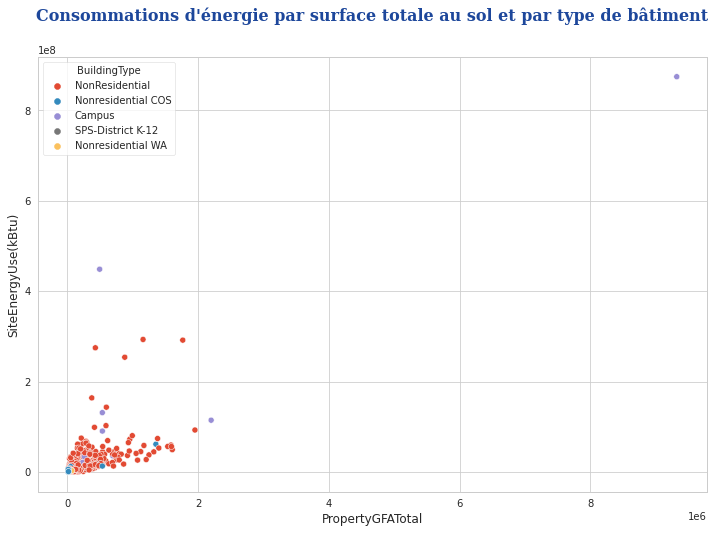

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-surface.png")
plt.show()

Un bâtiment de type campus est très supérieur aux autres données. Il ne s'agit sans doute pas d'une valeur abérrante mais d'une valeur atypique qui est très isolée, nous poursuivons l'analyse afin de décider de la supprimer ou non de nos données sources.

Nous identifions le campus en question

In [ ]:
df[df['SiteEnergyUse(kBtu)']>8*10**8]

,OSEBuildingID,Neighborhood,Address,State,PrimaryPropertyType,BuildingType,PropertyName,NumberofFloors,PropertyGFATotal,DataYear,...,NaturalGas(kBtu),ZipCode,ENERGYSTARScore,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,haversine_distance
1507,49967,NORTHEAST,NE 45th St & Brooklyn Ave,WA,University,Campus,University of Washington - Seattle Campus,0,9320156,2016,...,0.0,98105.0,NaN,116,1,1.0,0.0,83965.369,0.0,3.612662


Garder cette valeur biaiserai notre dataset, nous décidons de la supprimer

In [ ]:
df = df[df['SiteEnergyUse(kBtu)']<8*10**8]

Refaire le graphe sans l'outlier

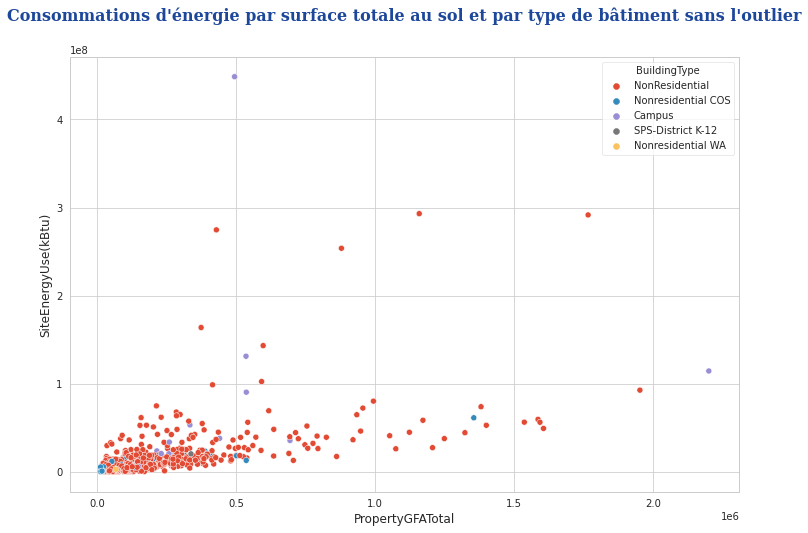

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment sans l'outlier\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-surface-sans-outlier.png")
plt.show()

Nous allons regrouper les données d'identification des bâtiments afin qu'elles ne perturbent pas nos modélisations mais restent utilisables.

In [ ]:
identification_features = ['OSEBuildingID', 'PropertyName', 'Address', 'ZipCode']
df_identification = df[identification_features]
df.drop(identification_features, axis=1, inplace = True)

Pour éviter le data leakage, c'est à dire prendre en compte des variables seulement observable au moment de la prédiction, nous allons exclure les variables de relevés

In [ ]:
df_filter = df.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(kBtu)'], axis=1)

Nous allons séparer les données numériques et les données catégorielles de notre dataset

In [ ]:
numerical_features = df_filter.select_dtypes(include=['int64','float64'])
categorical_features = df_filter.select_dtypes(exclude=['int64','float64'])

Pour les données catégorielles, nous allons devoir les encoder. Nous allons donc supprimer les variables qui n'apporteront rien à notre modèle (les constantes par exemple).

In [ ]:
categorical_features.nunique()

Neighborhood           19
State                   1
PrimaryPropertyType    21
BuildingType            5
dtype: int64

In [ ]:
categorical_features = categorical_features.drop(['State'], axis=1)

Regardons maintenant les données numériques :

In [ ]:
list(numerical_features.columns)

['NumberofFloors',
 'PropertyGFATotal',
 'DataYear',
 'SiteEnergyUse(kBtu)',
 'NumberofBuildings',
 'TotalGHGEmissions',
 'ENERGYSTARScore',
 'BuildingAge',
 'TotalUseTypeNumber',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor',
 'haversine_distance']

La date de relevé ne nous sera pas utile ici, nous la supprimerons du jeu de données. ENERGYSTARScore est insuffisement complété. Nous allons l'écarter du dataset mais nous la conservons pour vérifier ensuite si cette variable a un impact sur la qualité de prédiction.

In [ ]:
energystar_score = numerical_features['ENERGYSTARScore']
numerical_features = numerical_features.drop(['ENERGYSTARScore','DataYear'], axis=1)

Nous reconstituons le dataset qui servira à la modélisation et préparons le préprocessing des données en créant par la suite un pipeline

In [ ]:
df_filter = pd.concat([categorical_features, numerical_features], axis=1)

Nous allons analyser les boxplots de variables à prédire en fonction des variables catégorielles, afin de potentiellement regrouper certaines modalités similaires.

Nous créons cette fonction de mapping pour regrouper les modalités

In [ ]:
def group_categorical(category, **mapping):
    try:
        return mapping[category]
    except:
        return category

Nous commençons par 'SiteEnergyUse(kBtu)' en fonction de 'BuildingType'

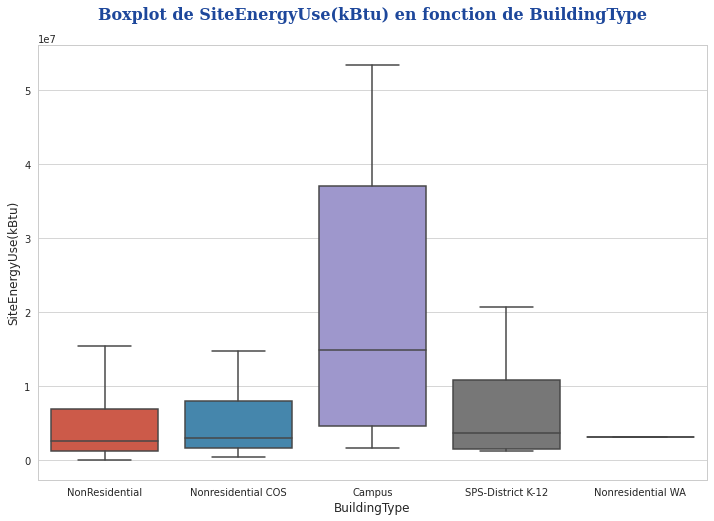

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
plt.figure(figsize=(12,8))
sns.boxplot(data=df_filter,x='BuildingType', y='SiteEnergyUse(kBtu)',showfliers = False)
plt.title(f"Boxplot de SiteEnergyUse(kBtu) en fonction de BuildingType\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-type-de-batiment.png")
plt.show()

Nous constatons que les buildings de type 'NonResidential' et 'NonResidential COS' ont des box quasi-similaires, nous pourrons éventuellement les regrouper en une seule variable.

In [ ]:
df_filter['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Campus',
       'SPS-District K-12', 'Nonresidential WA'], dtype=object)

In [ ]:
mapping = {'Nonresidential COS':'NonResidential'}
df_filter['NewBuildingType'] = df_filter['BuildingType'].apply(group_categorical, **mapping, axis=1)
df_filter['NewBuildingType'].unique()

array(['NonResidential', 'Campus', 'SPS-District K-12',
       'Nonresidential WA'], dtype=object)

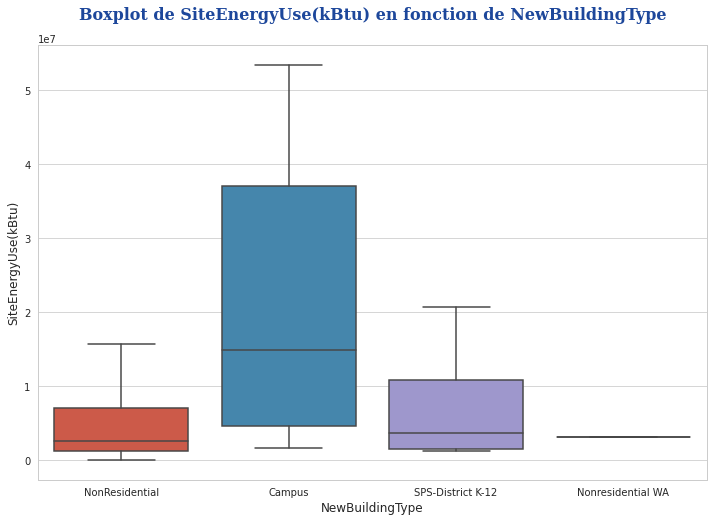

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
plt.figure(figsize=(12,8))
sns.boxplot(data=df_filter,x='NewBuildingType', y='SiteEnergyUse(kBtu)',showfliers = False)
plt.title(f"Boxplot de SiteEnergyUse(kBtu) en fonction de NewBuildingType\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-new-type-de-batiment1.png")
plt.show()

Nous allons à présent analyser 'SiteEnergyUse(kBtu)' en fonction du 'Neighborhood'

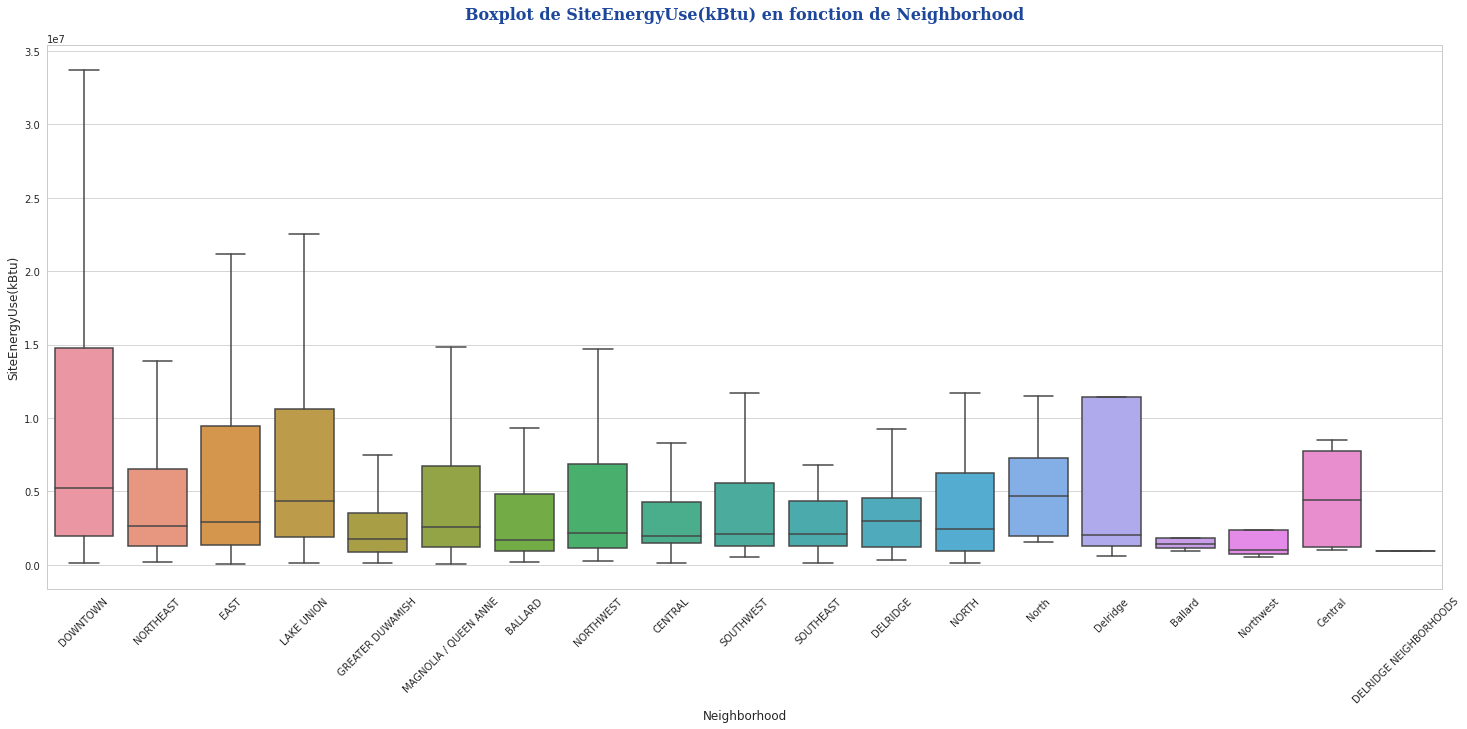

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
plt.figure(figsize=(25,10))
ax = sns.boxplot(data=df_filter,x='Neighborhood', y='SiteEnergyUse(kBtu)',showfliers = False)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title(f"Boxplot de SiteEnergyUse(kBtu) en fonction de Neighborhood\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-voisinage.png")
plt.show()

Nous constatons que certaines modalités sont identiques, les mêmes modalités sont en minuscule et en majuscule par exemple CENTRAL et Central, DELRIDGE et Delridge etc....

Nous allons procéder au regroupement de certaines modalités

In [ ]:
df_filter['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'NORTHWEST', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH', 'North', 'Delridge',
       'Ballard', 'Northwest', 'Central', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [ ]:
mapping = {'Central':'CENTRAL','Northwest':'NORTHWEST','North':'NORTH','Delridge':'DELRIDGE','Ballard':'BALLARD'}
df_filter['NewNeighborhood'] = df_filter['Neighborhood'].apply(group_categorical, **mapping, axis=1)
df_filter['NewNeighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'NORTHWEST', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

Nous affichons à nouveau la consommation d'énergie en fonction du voisinage

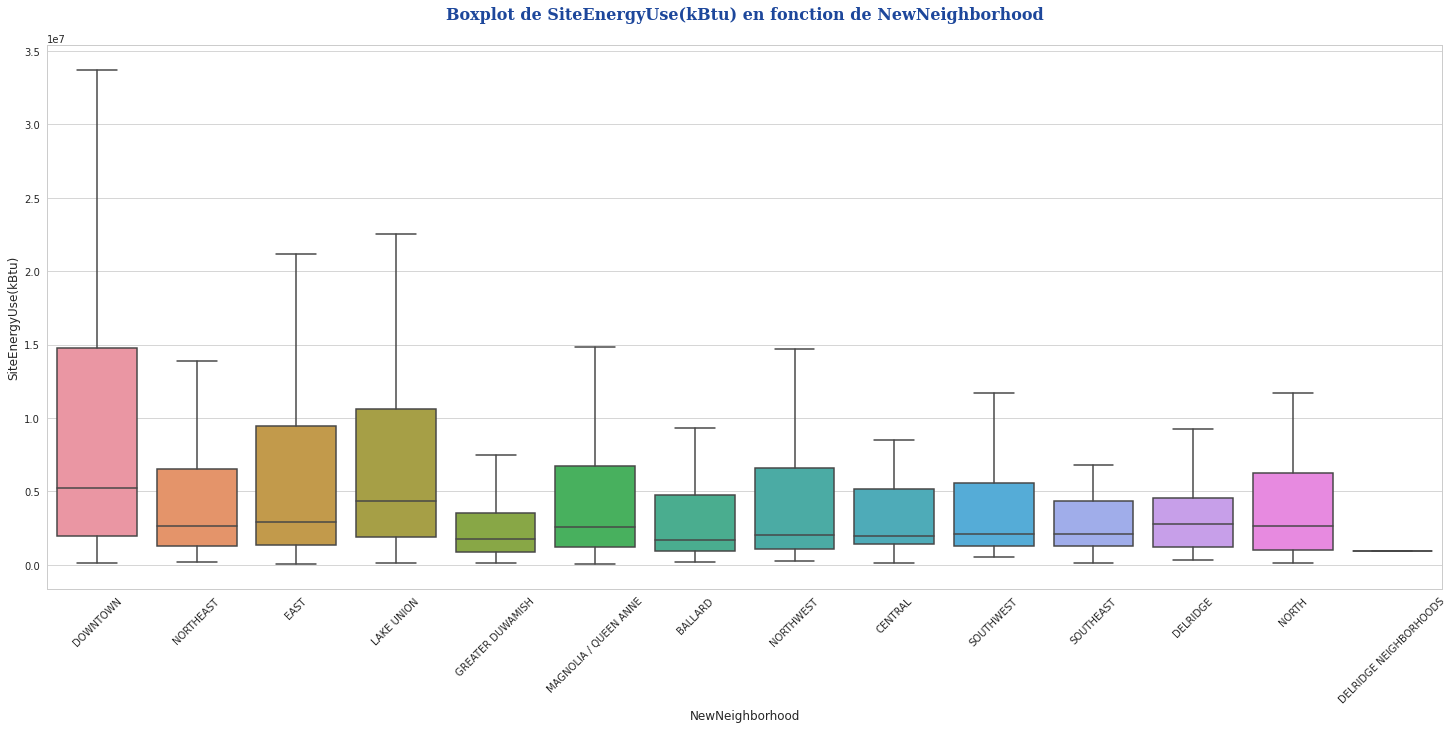

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
plt.figure(figsize=(25,10))
ax = sns.boxplot(data=df_filter,x='NewNeighborhood', y='SiteEnergyUse(kBtu)',showfliers = False)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title(f"Boxplot de SiteEnergyUse(kBtu) en fonction de NewNeighborhood\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-new-voisinage1.png")
plt.show()

Nous constatons encore des similarités de modalités : NORTHEAST et NORTH, MAGNOLIA/QUEEN ANNE et NORTHWEST, BALLARD et CENTRAL, GREATER DUWAMISH et SOUTHEAST

On refait un nouveau regroupement

In [ ]:
mapping = {'MAGNOLIA/QUEEN ANNE':'NORTHWEST','NORTHEAST':'NORTH','BALLARD':'CENTRAL','GREATER DUWAMISH':'SOUTHEAST'}
df_filter['NewNeighborhood'] = df_filter['NewNeighborhood'].apply(group_categorical, **mapping, axis=1)
df_filter['NewNeighborhood'].unique()

array(['DOWNTOWN', 'NORTH', 'EAST', 'LAKE UNION', 'SOUTHEAST',
       'MAGNOLIA / QUEEN ANNE', 'CENTRAL', 'NORTHWEST', 'SOUTHWEST',
       'DELRIDGE', 'DELRIDGE NEIGHBORHOODS'], dtype=object)

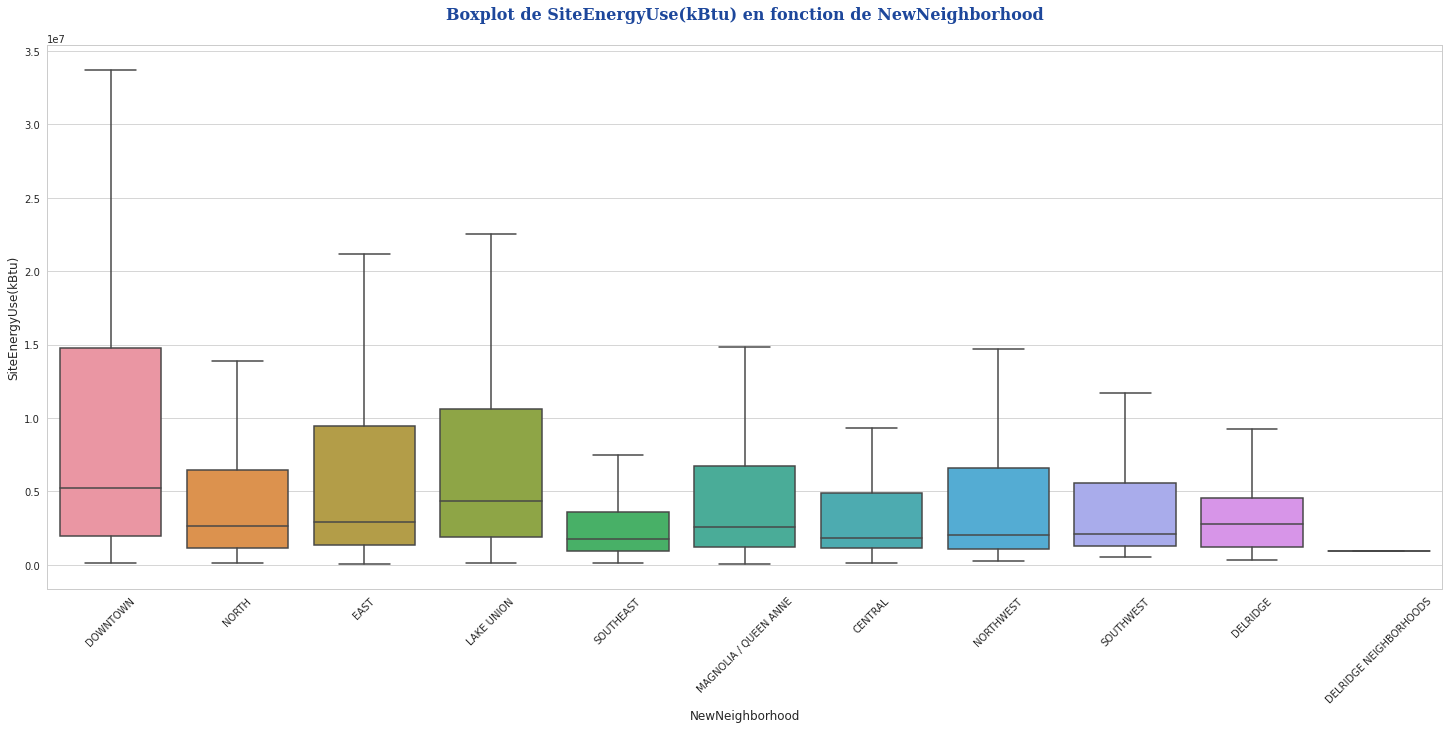

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
plt.figure(figsize=(25,10))
ax = sns.boxplot(data=df_filter,x='NewNeighborhood', y='SiteEnergyUse(kBtu)',showfliers = False)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title(f"Boxplot de SiteEnergyUse(kBtu) en fonction de NewNeighborhood\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-new-voisinage2.png")
plt.show()

Nous allons maintenant analyser 'SiteEnergyUse(kBtu)' en fonction du 'PrimaryPropertyType'

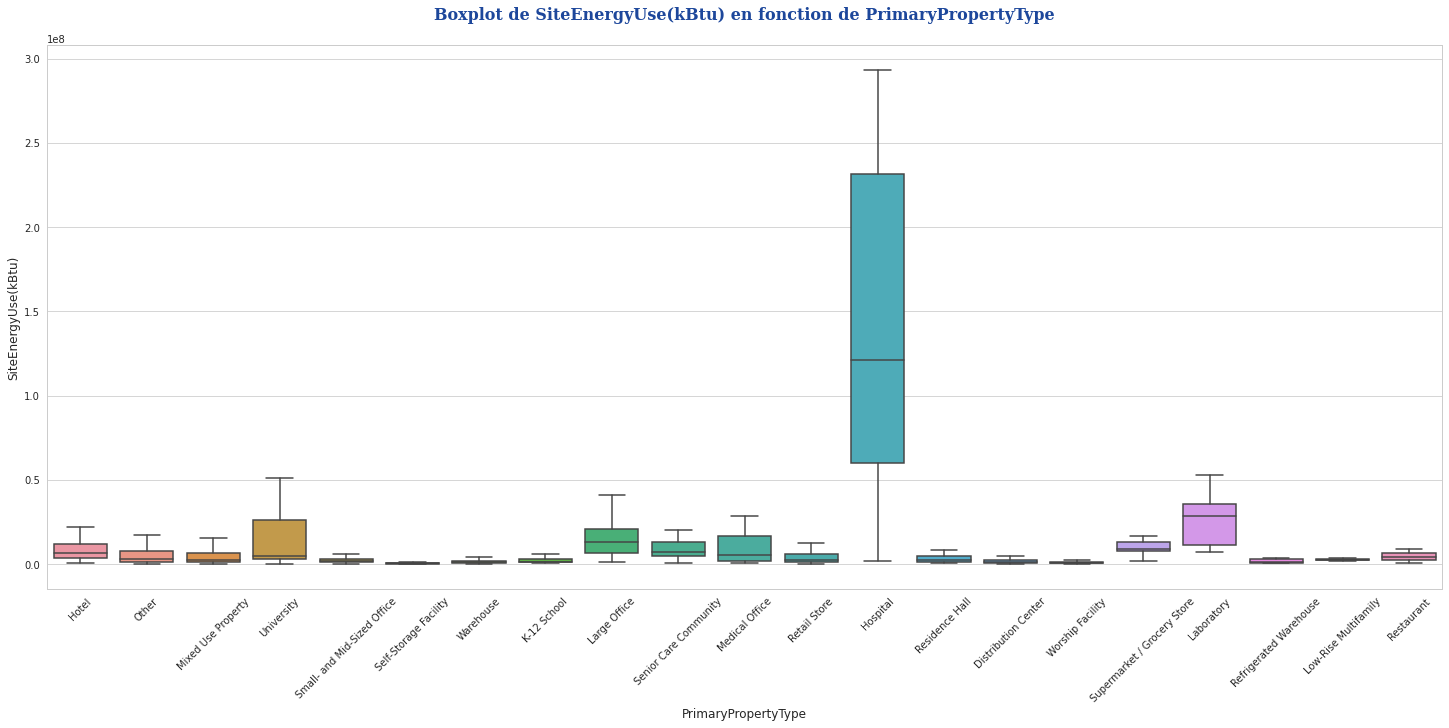

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
plt.figure(figsize=(25,10))
ax = sns.boxplot(data=df_filter,x='PrimaryPropertyType', y='SiteEnergyUse(kBtu)',showfliers = False)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title(f"Boxplot de SiteEnergyUse(kBtu) en fonction de PrimaryPropertyType\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-type-de-batiment-primaire.png")
plt.show()

On se rend compte que l'echelle surdimensionnée du box des rejets de CO2 des hôpitaux créent l'affaissement des autres box, nous allons alors le retirer de l'affichage

In [ ]:
df_filter2 = df_filter[df_filter['PrimaryPropertyType']!='Hospital']

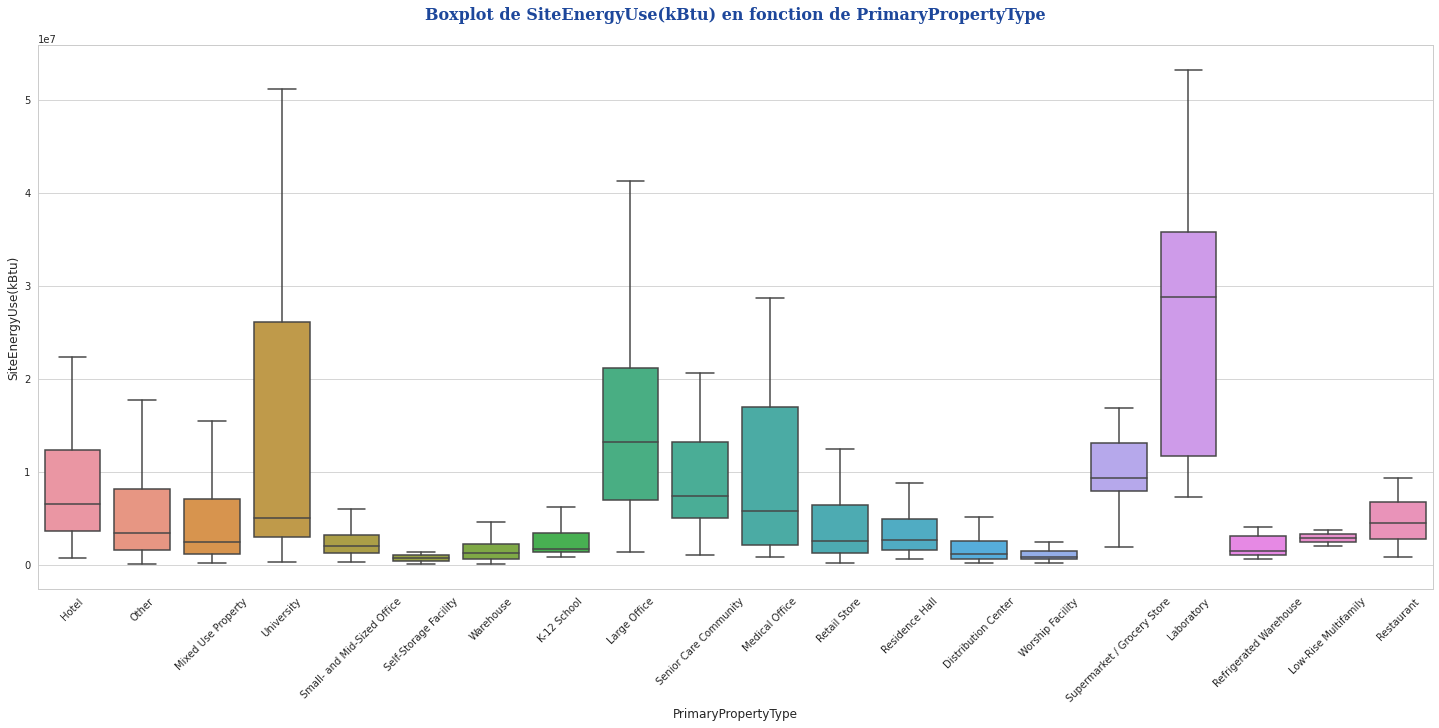

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
plt.figure(figsize=(25,10))
ax = sns.boxplot(data=df_filter2,x='PrimaryPropertyType', y='SiteEnergyUse(kBtu)',showfliers = False)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title(f"Boxplot de SiteEnergyUse(kBtu) en fonction de PrimaryPropertyType\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-type-de-batiment-primaire-sans-hopital1.png")
plt.show()

Le retrait de l'hôpital nous permet en effet de mieux visualiser les box et d'identifier les modalités similaires et de les regrouper.

Nous allons regrouper les modalités suivantes : Senior Care Community et Hotel, Mixed Use Property et Other, Small- and Mid-Sized Office et K-12 School, Warehouse et Refrigerated Warehouse


In [ ]:
mapping = {'Senior Care Community':'Hotel','Other':'Mixed Use Property','Refrigerated Warehouse':'Warehouse','K-12 School':'Small- and Mid-Sized Office'}
df_filter['NewPrimaryPropertyType'] = df_filter['PrimaryPropertyType'].apply(group_categorical, **mapping, axis=1)
df_filter['NewPrimaryPropertyType'].unique()

array(['Hotel', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Warehouse', 'Large Office', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Low-Rise Multifamily', 'Restaurant'], dtype=object)

Nous affichons après le regroupement

In [ ]:
df_filter3 = df_filter[df_filter['NewPrimaryPropertyType']!='Hospital']

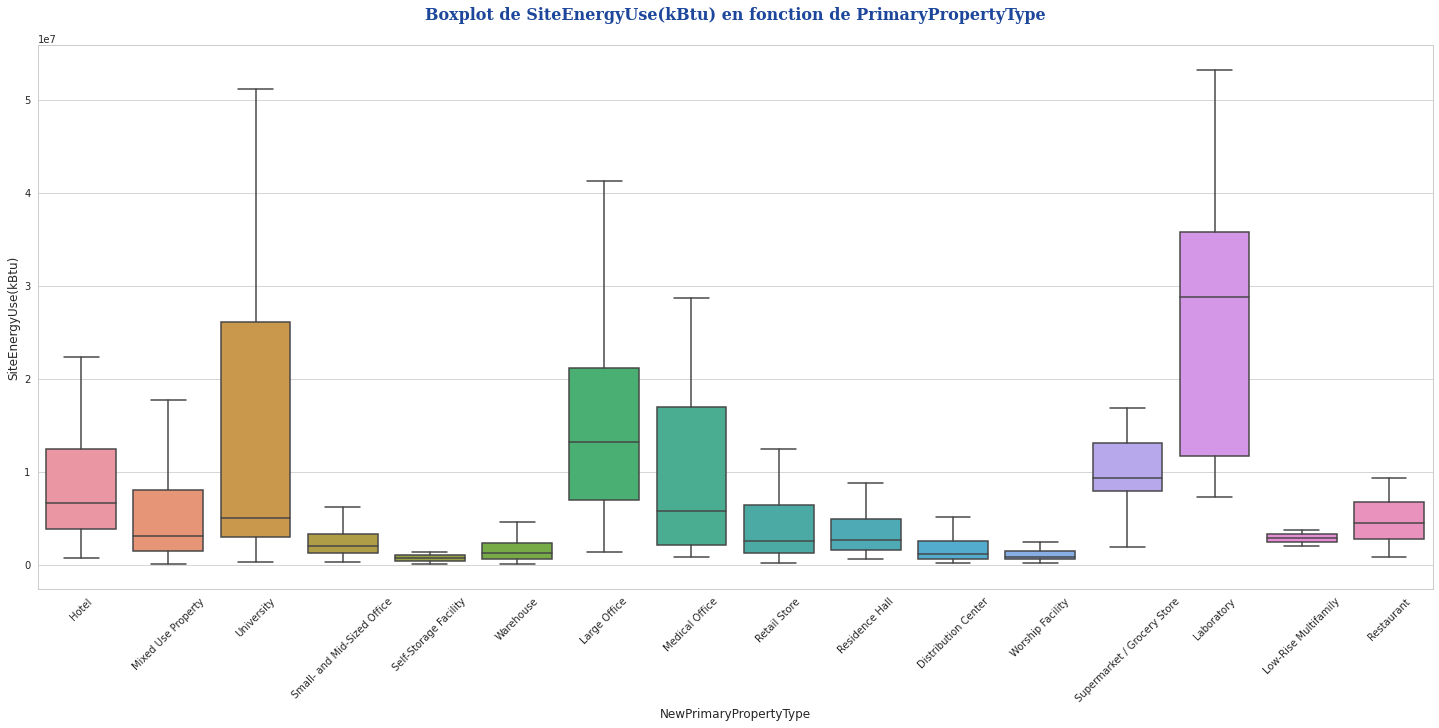

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
plt.figure(figsize=(25,10))
ax = sns.boxplot(data=df_filter3,x='NewPrimaryPropertyType', y='SiteEnergyUse(kBtu)',showfliers = False)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title(f"Boxplot de SiteEnergyUse(kBtu) en fonction de PrimaryPropertyType\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-type-de-batiment-primaire-sans-hopital2.png")
plt.show()

Nous pouvons encore regrouper Worship Facility et Self-Storage Facility, Distribution Center et Warehouse

In [ ]:
mapping = {'Worship Facility':'Self-Storage Facility','Distribution Center':'Warehouse'}
df_filter['NewPrimaryPropertyType'] = df_filter['NewPrimaryPropertyType'].apply(group_categorical, **mapping, axis=1)
df_filter['NewPrimaryPropertyType'].unique()

array(['Hotel', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Warehouse', 'Large Office', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Supermarket / Grocery Store',
       'Laboratory', 'Low-Rise Multifamily', 'Restaurant'], dtype=object)

In [ ]:
df_filter4 = df_filter[df_filter['NewPrimaryPropertyType']!='Hospital']

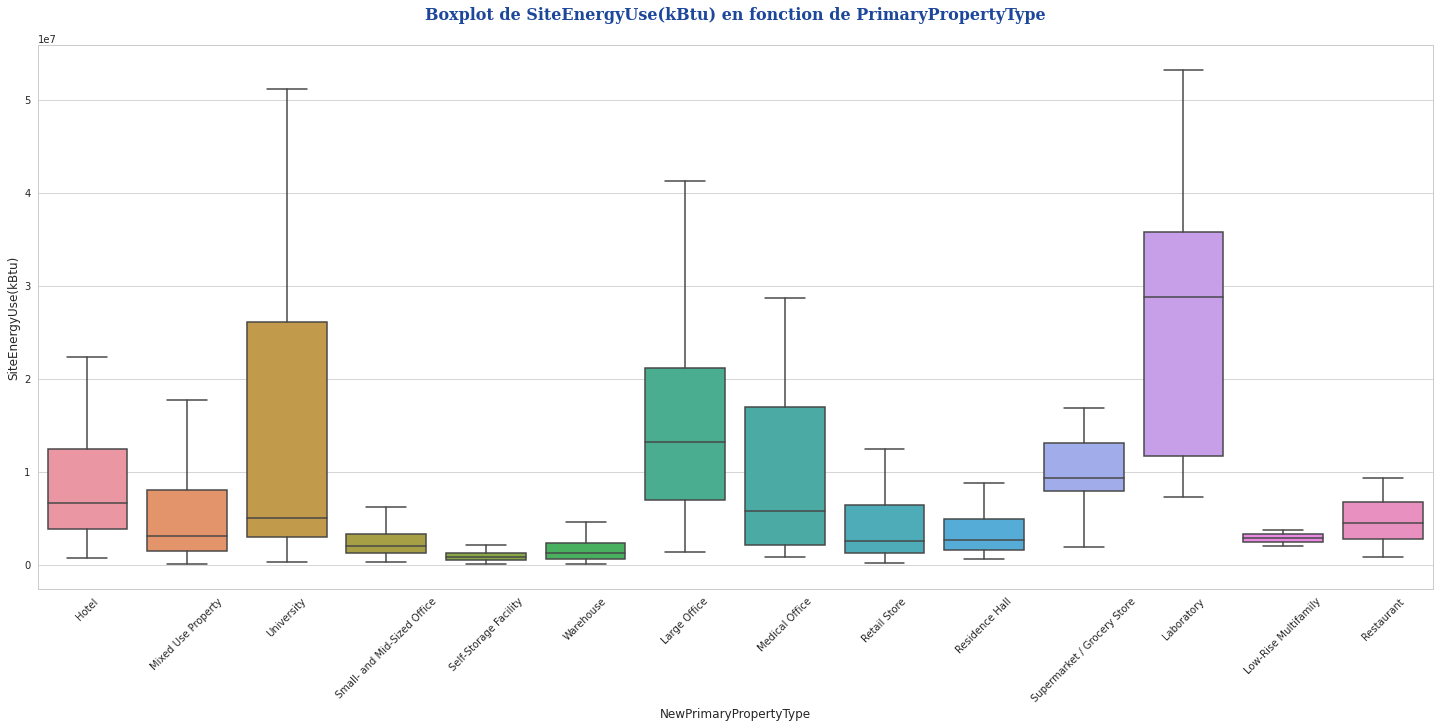

In [ ]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }
plt.figure(figsize=(25,10))
ax = sns.boxplot(data=df_filter4,x='NewPrimaryPropertyType', y='SiteEnergyUse(kBtu)',showfliers = False)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title(f"Boxplot de SiteEnergyUse(kBtu) en fonction de PrimaryPropertyType\n",
          fontdict=font_title, fontsize=16)
plt.savefig("../images/sea/seu-par-type-de-batiment-primaire-sans-hopital3.png")
plt.show()

Nous supprimons les 3 variables catégorielles que nous venons de modifier

In [ ]:
df_final = df_filter.drop(['BuildingType','Neighborhood','PrimaryPropertyType'], axis=1)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544 entries, 0 to 1544
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NumberofFloors          1544 non-null   int64  
 1   PropertyGFATotal        1544 non-null   int64  
 2   SiteEnergyUse(kBtu)     1544 non-null   float64
 3   NumberofBuildings       1544 non-null   float64
 4   TotalGHGEmissions       1544 non-null   float64
 5   BuildingAge             1544 non-null   int64  
 6   TotalUseTypeNumber      1544 non-null   int64  
 7   GFABuildingRate         1544 non-null   float64
 8   GFAParkingRate          1544 non-null   float64
 9   GFAPerBuilding          1544 non-null   float64
 10  GFAPerFloor             1544 non-null   float64
 11  haversine_distance      1544 non-null   float64
 12  NewBuildingType         1544 non-null   object 
 13  NewNeighborhood         1544 non-null   object 
 14  NewPrimaryPropertyType  1544 non-null   

Nous créons les objets du preprocessing

In [ ]:
# Préparation du Preprocessor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['NewBuildingType','NewPrimaryPropertyType','NewNeighborhood']
categorical_transformer = OneHotEncoder()

numeric_features = ['haversine_distance','NumberofBuildings','NumberofFloors',
                    'PropertyGFATotal','BuildingAge','TotalUseTypeNumber',
                    'GFABuildingRate','GFAParkingRate','GFAPerBuilding','GFAPerFloor']
numeric_transformer = RobustScaler(unit_variance=True)

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_features),
    ('numeric', numeric_transformer, numeric_features)
])

Nous allons analyser l'impact du passage à l'échelle logarithmique

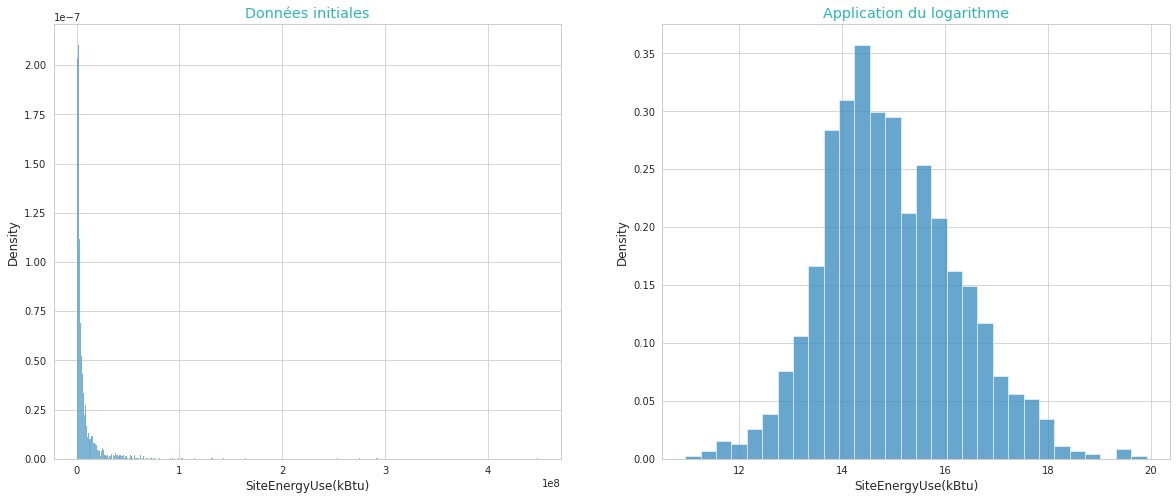

In [ ]:
X = df_final.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
Y = df_final[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]
import numpy as np
Y_log = np.log(Y)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
#plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.savefig("../images/sea/seu-distribution-avec-echelle.png")
plt.show()

En passant les données à l'échelle logarithmique, nous obtenons une distribution normale des données à prédire. Nous allons donc appliquer cette transformation dans notre pipeline et voir son apport dans l'amélioration des performances des modèles

### **2.&nbsp;Modèles linéaires**

### **2.1.&nbsp;LinearRegression**

Nous allons calculer 2 principales métriques pour évaluer nos modèles :

* MAE : Mean Absolute Error.
* R² : Coeficient de détermination, carré du coefficient de corrélation linéaire.

Nous créons une fonction de calcul des scores des modèles

In [ ]:
#Retour des meilleurs scores NMAE et R2
#Stockage du dataframe de resultats du modèle
def model_scores(pip,step):
    df_results = pd.DataFrame.from_dict(pip.named_steps[step].cv_results_).sort_values('rank_test_neg_mean_absolute_error')#neg_mean_absolute_error
    best_nmae = pip.named_steps[step].best_score_
    best_r2 = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_r2'])
    best_params = pip.named_steps[step].best_params_
    training_time = round((np.mean(df_results.mean_fit_time)*X_train_transf.shape[0]),2)
    print("Meilleur score MAE : {}\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}s"\
         .format(round(best_nmae,3), round(best_r2,3), best_params, training_time))
    return df_results

Nous appliquons le preprocessing

In [ ]:
X_transf = preprocessor.fit_transform(X)

Nous allons donc spliter nos données transformées pour obtenir un jeu d'entrainement et un jeu de test (20% des données)



In [ ]:
from sklearn.model_selection import train_test_split
X_train_transf, X_test_transf, Y_train_transf, Y_test_transf = train_test_split(X_transf, Y, test_size=0.2, random_state=42)

Nous allons tester le modèle linéaire sans log transformation

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
set_config(display='diagram')


param_mlr = {"regressor__fit_intercept": [True, False],
             "regressor__normalize": [True, False]}

mlr_grid_cv = Pipeline([
    ('grid_search_mlr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearRegression()),
                            param_grid=param_mlr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [ ]:
SEU_mlr_model = mlr_grid_cv.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_mlr_results = model_scores(SEU_mlr_model, 'grid_search_mlr')

Meilleur score MAE : -4745524.011
Meilleur Score R2 : 0.468
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': False}
Temps moyen d'entrainement : 9.6s


Nous allons maintenant tester le modèle linéaire avec log transformation

In [ ]:
param_mlr = {"regressor__fit_intercept": [True, False],
             "regressor__normalize": [True, False]}

mlr_grid_cv_log = Pipeline([
    ('grid_search_mlr_log', GridSearchCV(
                            TransformedTargetRegressor(
                              regressor=LinearRegression(),
                              func=np.log,
                              inverse_func=np.exp),
                            param_grid=param_mlr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [ ]:
SEU_mlr_model_log = mlr_grid_cv_log.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_mlr_results_log = model_scores(SEU_mlr_model_log, 'grid_search_mlr_log')

Meilleur score MAE : -8495329.828
Meilleur Score R2 : -8.701
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': True}
Temps moyen d'entrainement : 8.37s


On constate que l'application de la log transformation détériore les performances du modèle

### **2.2.&nbsp;ElasticNet**

Nous allons tester le modèle sans log transformation

In [ ]:
from sklearn.linear_model import ElasticNet

param_eNet = {"regressor__max_iter": [10, 100, 1000],
              "regressor__alpha": np.logspace(-4, 0, num=5),
              "regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv = Pipeline([
    ('grid_search_eNet', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=ElasticNet()),
                            param_grid=param_eNet,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [ ]:
SEU_eNet_model = eNet_grid_cv.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_eNet_results = model_scores(SEU_eNet_model, 'grid_search_eNet')

Meilleur score MAE : -4733389.311
Meilleur Score R2 : 0.509
Meilleurs paramètres : {'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.4, 'regressor__max_iter': 100}
Temps moyen d'entrainement : 24.78s


Nous allons maintenant entrainer le modèle avec la log transformation

In [ ]:
param_eNet = {"regressor__max_iter": [10, 100, 1000],
              "regressor__alpha": np.logspace(-4, 0, num=5),
              "regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv_log = Pipeline([
    ('grid_search_eNet_log', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=ElasticNet(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_grid=param_eNet,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [ ]:
SEU_eNet_model_log = eNet_grid_cv_log.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_eNet_results_log = model_scores(SEU_eNet_model_log, 'grid_search_eNet_log')

Meilleur score MAE : -5914676.268
Meilleur Score R2 : 0.051
Meilleurs paramètres : {'regressor__alpha': 1.0, 'regressor__l1_ratio': 1.0, 'regressor__max_iter': 10}
Temps moyen d'entrainement : 11.96s


On fait le même constat que pour la régression linéaire, la log transformation ne permet pas d'améliorer les performanecs du modèle

### **3.1.&nbsp;RandomForest**

Nous commençons par entrainer sans la log transformation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
param_rfr = {'regressor__max_features' : ['sqrt', 'log2'],
             'regressor__max_depth': [5, 15, 25],
             'regressor__min_samples_split': [2, 5, 10],
             'regressor__bootstrap' : [True, False],
             'regressor__min_samples_leaf': [1,2,5]}

rfr_grid_cv = Pipeline([
    ('grid_search_rfr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor()),
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_rfr_model = rfr_grid_cv.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_rfr_results = model_scores(SEU_rfr_model, 'grid_search_rfr')

Meilleur score MAE : -3966677.604
Meilleur Score R2 : 0.603
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Temps moyen d'entrainement : 407.11s


Nous allons entrainer avec la log transformation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
param_rfr = {'regressor__max_features' : ['sqrt', 'log2'],
             'regressor__max_depth': [5, 15, 25],
             'regressor__min_samples_split': [2, 5, 10],
             'regressor__bootstrap' : [True, False],
             'regressor__min_samples_leaf': [1,2,5]}

rfr_grid_cv_log = Pipeline([
    ('grid_search_rfr_log', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_rfr_model_log = rfr_grid_cv_log.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_rfr_results_log = model_scores(SEU_rfr_model_log, 'grid_search_rfr_log')

Meilleur score MAE : -3887822.205
Meilleur Score R2 : 0.509
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 15, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}
Temps moyen d'entrainement : 390.57s


Nous pouvons voir que dans ce cas l'application de la log transformation améliore le MAE mais détériore le R2

### **3.2.&nbsp;XGBoost**

Nous commençons sans la log transformation

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.01, 0.1, 0.2, 0,3],
             'regressor__gamma': [0, 0.25, 0.5, 1.0],
             'regressor__max_depth': [3, 5, 7, 10],
             'regressor__min_child_weight' : [1.0, 3.0, 5.0, 7.0],
             'regressor__n_estimators': [50, 100, 500, 1000],
             'regressor__subsample': [0.5,0.6,0.7,0.8],
             'regressor__colsample_bytree':[0.5,0.6,0.7,0.8]}
xgb_grid_cv = Pipeline([
    ('grid_search_xgb', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor()),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model = xgb_grid_cv.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results = model_scores(SEU_xgb_model, 'grid_search_xgb')

[23:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3944266.567
Meilleur Score R2 : 0.524
Meilleurs paramètres : {'regressor__subsample': 0.7, 'regressor__n_estimators': 1000, 'regressor__min_child_weight': 1.0, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0.5, 'regressor__colsample_bytree': 0.7}
Temps moyen d'entrainement : 1140.03s


Nous entrainons avec la log transformation

In [ ]:
param_xgb = {'regressor__learning_rate' : [0.01, 0.1, 0.2, 0,3],
             'regressor__gamma': [0, 0.25, 0.5, 1.0],
             'regressor__max_depth': [3, 5, 7, 10],
             'regressor__min_child_weight' : [1.0, 3.0, 5.0, 7.0],
             'regressor__n_estimators': [50, 100, 500, 1000],
             'regressor__subsample': [0.5,0.6,0.7,0.8],
             'regressor__colsample_bytree':[0.5,0.6,0.7,0.8]}
xgb_grid_cv_log = Pipeline([
    ('grid_search_xgb_log', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model_log = xgb_grid_cv_log.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log = model_scores(SEU_xgb_model_log, 'grid_search_xgb_log')

[23:04:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3670005.935
Meilleur Score R2 : 0.627
Meilleurs paramètres : {'regressor__subsample': 0.7, 'regressor__n_estimators': 500, 'regressor__min_child_weight': 1.0, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.25, 'regressor__colsample_bytree': 0.7}
Temps moyen d'entrainement : 1684.76s


### **4.&nbsp;Sélection du meilleur modèle**

Nous allons afficher les performances et le temps d'entrainement des modèles

In [ ]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']
SEU_compare_metrics = pd.concat([pd.DataFrame(SEU_rfr_results[metrics].max(), columns=['RandomForest']),
                                 pd.DataFrame(SEU_xgb_results[metrics].max(), columns=['XGBoost']),
                                 pd.DataFrame(SEU_eNet_results[metrics].max(), columns=['ElasticNet']),
                                 pd.DataFrame(SEU_mlr_results[metrics].max(), columns=['LinearRegression'])
                                ], axis=1)

SEU_final_metrics_compare = SEU_compare_metrics.T

mapping = {SEU_final_metrics_compare.columns[0]: 'max_fit_time', SEU_final_metrics_compare.columns[1]: 'max_score_time', SEU_final_metrics_compare.columns[2]: 'max_test_neg_mean_absolute_error', SEU_final_metrics_compare.columns[3]: 'max_train_neg_mean_absolute_error'}

SEU_final_metrics_compare = SEU_final_metrics_compare.rename(columns=mapping)


In [ ]:
SEU_final_metrics_compare

,max_fit_time,max_score_time,max_test_neg_mean_absolute_error,max_train_neg_mean_absolute_error
RandomForest,0.500863,0.034313,-3.998160e+06,-3.986729e+04
XGBoost,6.160559,0.044679,-4.108750e+06,-9.280315e+02
ElasticNet,0.063739,0.003674,-4.733389e+06,-4.415722e+06
LinearRegression,0.008094,0.002398,-4.745524e+06,-4.415735e+06


In [ ]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']
SEU_compare_metrics_log = pd.concat([pd.DataFrame(SEU_rfr_results_log[metrics].max(), columns=['RandomForest']),
                                 pd.DataFrame(SEU_xgb_results_log[metrics].max(), columns=['XGBoost']),
                                 pd.DataFrame(SEU_eNet_results_log[metrics].max(), columns=['ElasticNet']),
                                 pd.DataFrame(SEU_mlr_results_log[metrics].max(), columns=['LinearRegression'])
                                ], axis=1)

SEU_final_metrics_compare_log = SEU_compare_metrics_log.T

mapping = {SEU_final_metrics_compare_log.columns[0]: 'max_fit_time', SEU_final_metrics_compare_log.columns[1]: 'max_score_time', SEU_final_metrics_compare_log.columns[2]: 'max_test_neg_mean_absolute_error', SEU_final_metrics_compare_log.columns[3]: 'max_train_neg_mean_absolute_error'}

SEU_final_metrics_compare_log = SEU_final_metrics_compare_log.rename(columns=mapping)

In [ ]:
SEU_final_metrics_compare_log

,max_fit_time,max_score_time,max_test_neg_mean_absolute_error,max_train_neg_mean_absolute_error
RandomForest,0.511432,0.036657,-3.849657e+06,-1.368971e+04
XGBoost,2.971167,0.020741,-3.636116e+06,-2.910089e+04
ElasticNet,0.062254,0.005588,-5.914676e+06,-5.884310e+06
LinearRegression,0.006022,0.001888,-8.495330e+06,-5.959770e+06


On voit visiblement que XGBoost avec la log transformation a de meilleurs performances que les autres modèles.

Après une construction du modèle via la cross validation, nous allons maintenant essayer de fine tuner les paramètres afin de construire le meilleur modèle.

Nous fixons le learning_rate à 0.1 pour commencer avec d'autres parametres et faisons une cross validation (cv) sur le nombre d'arbres (n_estimators)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.1],
             'regressor__gamma': [0],
             'regressor__max_depth': [5],
             'regressor__min_child_weight' : [1],
             'regressor__n_estimators': [100,200,300],
             'regressor__subsample': [0.8],
             'regressor__colsample_bytree': [0.8]}
xgb_grid_cv_log_tune = Pipeline([
    ('grid_search_xgb_log_tune', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model_log_tune = xgb_grid_cv_log_tune.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune = model_scores(SEU_xgb_model_log_tune, 'grid_search_xgb_log_tune')

[14:36:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3709822.928
Meilleur Score R2 : 0.592
Meilleurs paramètres : {'regressor__subsample': 0.8, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.8}
Temps moyen d'entrainement : 789.04s


On refait le tuning en essayant de resserer les valeurs de n_estimators autour de 100

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.1],
             'regressor__gamma': [0],
             'regressor__max_depth': [5],
             'regressor__min_child_weight' : [1],
             'regressor__n_estimators': [50,100,150],
             'regressor__subsample': [0.8],
             'regressor__colsample_bytree': [0.8]}
xgb_grid_cv_log_tune = Pipeline([
    ('grid_search_xgb_log_tune', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model_log_tune = xgb_grid_cv_log_tune.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune = model_scores(SEU_xgb_model_log_tune, 'grid_search_xgb_log_tune')

[14:37:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3709822.928
Meilleur Score R2 : 0.592
Meilleurs paramètres : {'regressor__subsample': 0.8, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.8}
Temps moyen d'entrainement : 391.91s


Le meilleur nombre d'arbres est 100, nous allons fixer le nombre d'arbres et faire une cv sur le max_depth et le min_child_weight

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.1],
             'regressor__gamma': [0],
             'regressor__max_depth': [3,5,7,9],
             'regressor__min_child_weight' : [1.0, 3.0, 5.0, 7.0],
             'regressor__n_estimators': [100],
             'regressor__subsample': [0.8],
             'regressor__colsample_bytree': [0.8]}
xgb_grid_cv_log_tune = Pipeline([
    ('grid_search_xgb_log_tune', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model_log_tune = xgb_grid_cv_log_tune.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune = model_scores(SEU_xgb_model_log_tune, 'grid_search_xgb_log_tune')

[14:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3665677.679
Meilleur Score R2 : 0.606
Meilleurs paramètres : {'regressor__subsample': 0.8, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.0, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.8}
Temps moyen d'entrainement : 452.28s


La meilleur valeur pour max_depth est 7 et min_child_weight est 1. Nous allons maintenant regarder les cas où on fait une cv avec plus ou moins 1 à ces valeurs

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.1],
             'regressor__gamma': [0],
             'regressor__max_depth': [6,7,8],
             'regressor__min_child_weight' : [0.5, 1.0, 1.5, 2.0],
             'regressor__n_estimators': [100],
             'regressor__subsample': [0.8],
             'regressor__colsample_bytree': [0.8]}
xgb_grid_cv_log_tune = Pipeline([
    ('grid_search_xgb_log_tune', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model_log_tune = xgb_grid_cv_log_tune.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune = model_scores(SEU_xgb_model_log_tune, 'grid_search_xgb_log_tune')

[14:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3602371.1
Meilleur Score R2 : 0.618
Meilleurs paramètres : {'regressor__subsample': 0.8, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.5, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.8}
Temps moyen d'entrainement : 535.71s


La meilleur valeur pour max_depth est 6 et min_child_weight est 1.5

Nous allons maintenant fine tuner gamma

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.1],
             'regressor__gamma': [i/10.0 for i in range(0,5)],
             'regressor__max_depth': [6],
             'regressor__min_child_weight' : [1.5],
             'regressor__n_estimators': [100],
             'regressor__subsample': [0.8],
             'regressor__colsample_bytree': [0.8]}
xgb_grid_cv_log_tune = Pipeline([
    ('grid_search_xgb_log_tune', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model_log_tune = xgb_grid_cv_log_tune.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune = model_scores(SEU_xgb_model_log_tune, 'grid_search_xgb_log_tune')

[14:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3589253.452
Meilleur Score R2 : 0.617
Meilleurs paramètres : {'regressor__subsample': 0.8, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.5, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.8}
Temps moyen d'entrainement : 457.79s


Nous allons conserver gamma 0.4 et nous allons maintenant tuner subsample et colsample_bytree

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.1],
             'regressor__gamma': [0.4],
             'regressor__max_depth': [6],
             'regressor__min_child_weight' : [1.5],
             'regressor__n_estimators': [100],
             'regressor__subsample': [i/10.0 for i in range(6,10)],
             'regressor__colsample_bytree': [i/10.0 for i in range(6,10)]}
xgb_grid_cv_log_tune = Pipeline([
    ('grid_search_xgb_log_tune', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model_log_tune = xgb_grid_cv_log_tune.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune = model_scores(SEU_xgb_model_log_tune, 'grid_search_xgb_log_tune')

[14:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3509342.792
Meilleur Score R2 : 0.627
Meilleurs paramètres : {'regressor__subsample': 0.7, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.5, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.9}
Temps moyen d'entrainement : 509.85s


La valeur optimale pour subsample est 0.7 et colsample_bytree est 0.9

Nous allons maintenant tuner les paramètres de régularisation alpha et lambda

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.1],
             'regressor__gamma': [0.4],
             'regressor__max_depth': [6],
             'regressor__min_child_weight' : [1.5],
             'regressor__n_estimators': [100],
             'regressor__subsample': [0.7],
             'regressor__colsample_bytree': [0.9],
             'regressor__reg_alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1],
             'regressor__reg_lambda' : [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]}
xgb_grid_cv_log_tune = Pipeline([
    ('grid_search_xgb_log_tune', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model_log_tune = xgb_grid_cv_log_tune.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune = model_scores(SEU_xgb_model_log_tune, 'grid_search_xgb_log_tune')

[14:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3481898.266
Meilleur Score R2 : 0.66
Meilleurs paramètres : {'regressor__subsample': 0.7, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.5, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.9}
Temps moyen d'entrainement : 541.79s


Les valeurs optimales sont donc 0.1 pour lambda et 0.1 pour alpha. Le modèle final est donc le suivant

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'regressor__learning_rate' : [0.1],
             'regressor__gamma': [0.4],
             'regressor__max_depth': [6],
             'regressor__min_child_weight' : [1.5],
             'regressor__n_estimators': [100],
             'regressor__subsample': [0.7],
             'regressor__colsample_bytree': [0.9],
             'regressor__reg_alpha' : [0.1],
             'regressor__reg_lambda' : [0.1]}
xgb_grid_cv_log_tune = Pipeline([
    ('grid_search_xgb_log_tune', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
SEU_xgb_model_log_tune = xgb_grid_cv_log_tune.fit(X_train_transf, Y_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune = model_scores(SEU_xgb_model_log_tune, 'grid_search_xgb_log_tune')

[15:06:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3481898.266
Meilleur Score R2 : 0.66
Meilleurs paramètres : {'regressor__subsample': 0.7, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.5, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.9}
Temps moyen d'entrainement : 521.96s


Nous allons tester différent xgboost en sélectionnantr les variables les plus significatives

In [ ]:
X_dum = pd.get_dummies(X, columns=['NewBuildingType','NewPrimaryPropertyType','NewNeighborhood'], prefix=['BuildingType','NewPrimaryPropertyType','NewNeighborhood'])

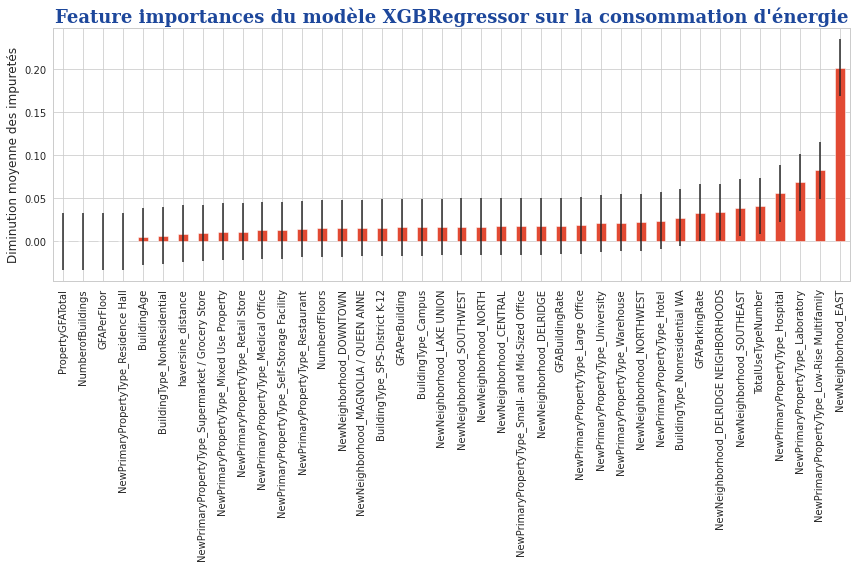

In [ ]:
feature_importance = SEU_xgb_model_log_tune.named_steps['grid_search_xgb_log_tune'].best_estimator_.regressor_.feature_importances_
feature_name = X_dum.columns
std = np.std([
    tree for tree in SEU_xgb_model_log_tune.named_steps['grid_search_xgb_log_tune'].best_estimator_.regressor_.feature_importances_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=feature_name)
df_feature_importance = df_feature_importance.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances du modèle XGBRegressor sur la consommation d'énergie", fontdict=font_title)
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

Nous allons retirer 'PropertyGFATotal'

In [ ]:
X_New = X.drop(columns=['PropertyGFATotal'], inplace=False, axis=1)

In [ ]:
categorical_features_ = ['NewBuildingType','NewPrimaryPropertyType','NewNeighborhood']
categorical_transformer_ = OneHotEncoder()

numeric_features_ = ['haversine_distance','NumberofBuildings','BuildingAge',
                    'TotalUseTypeNumber',
                    'GFABuildingRate','GFAParkingRate','GFAPerBuilding','GFAPerFloor']
numeric_transformer_ = RobustScaler(unit_variance=True)

preprocessor_ = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer_, categorical_features_),
    ('numeric', numeric_transformer_, numeric_features_)
])

In [ ]:
X_New_transf = preprocessor_.fit_transform(X_New)

In [ ]:
X_New_train_transf, X_New_test_transf, Y_New_train_transf, Y_New_test_transf = train_test_split(X_New_transf, Y, test_size=0.2, random_state=42)

In [ ]:
SEU_xgb_model_log_tune_new = xgb_grid_cv_log_tune.fit(X_New_train_transf, Y_New_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune_new = model_scores(SEU_xgb_model_log_tune_new, 'grid_search_xgb_log_tune')

[14:50:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3862969.317
Meilleur Score R2 : 0.534
Meilleurs paramètres : {'regressor__subsample': 0.7, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.5, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.9}
Temps moyen d'entrainement : 262.71s


On constate aucune amélioration du modèle, nous allons retirer NumberofBuildings

In [ ]:
X_New = X.drop(columns=['NumberofBuildings'], inplace=False, axis=1)

In [ ]:
categorical_features_ = ['NewBuildingType','NewPrimaryPropertyType','NewNeighborhood']
categorical_transformer_ = OneHotEncoder()

numeric_features_ = ['haversine_distance','PropertyGFATotal','BuildingAge',
                    'TotalUseTypeNumber',
                    'GFABuildingRate','GFAParkingRate','GFAPerBuilding','GFAPerFloor']
numeric_transformer_ = RobustScaler(unit_variance=True)

preprocessor_ = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer_, categorical_features_),
    ('numeric', numeric_transformer_, numeric_features_)
])

In [ ]:
X_New_transf = preprocessor_.fit_transform(X_New)

In [ ]:
X_New_train_transf, X_New_test_transf, Y_New_train_transf, Y_New_test_transf = train_test_split(X_New_transf, Y, test_size=0.2, random_state=42)

In [ ]:
SEU_xgb_model_log_tune_new = xgb_grid_cv_log_tune.fit(X_New_train_transf, Y_New_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune_new = model_scores(SEU_xgb_model_log_tune_new, 'grid_search_xgb_log_tune')

[14:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3682583.568
Meilleur Score R2 : 0.607
Meilleurs paramètres : {'regressor__subsample': 0.7, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.5, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.9}
Temps moyen d'entrainement : 275.32s


On constate une détérioration du modèle, nous dons retirer 'BuildingAge'

In [ ]:
X_New = X.drop(columns=['BuildingAge'], inplace=False, axis=1)

In [ ]:
categorical_features_ = ['NewBuildingType','NewPrimaryPropertyType','NewNeighborhood']
categorical_transformer_ = OneHotEncoder()

numeric_features_ = ['haversine_distance','PropertyGFATotal','NumberofBuildings',
                    'TotalUseTypeNumber',
                    'GFABuildingRate','GFAParkingRate','GFAPerBuilding','GFAPerFloor']
numeric_transformer_ = RobustScaler(unit_variance=True)

preprocessor_ = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer_, categorical_features_),
    ('numeric', numeric_transformer_, numeric_features_)
])

In [ ]:
X_New_transf = preprocessor_.fit_transform(X_New)

In [ ]:
X_New_train_transf, X_New_test_transf, Y_New_train_transf, Y_New_test_transf = train_test_split(X_New_transf, Y, test_size=0.2, random_state=42)

In [ ]:
SEU_xgb_model_log_tune_new = xgb_grid_cv_log_tune.fit(X_New_train_transf, Y_New_train_transf['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune_new = model_scores(SEU_xgb_model_log_tune_new, 'grid_search_xgb_log_tune')

[14:58:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3681348.746
Meilleur Score R2 : 0.597
Meilleurs paramètres : {'regressor__subsample': 0.7, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.5, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.9}
Temps moyen d'entrainement : 263.28s


Nous allons donc conserver le modèle avec toutes les features vue que le retrait des features censées être non significatives détériorent les performances du modèle finale choisi.

### **5.&nbsp;Influence de l'energy star score**

Le score ENERGY STAR fournit un aperçu complet de la performance énergétique d'un bâtiment, en tenant compte des actifs physiques, des opérations et du comportement des occupants du bâtiment. Il est exprimé sur une échelle de 1 à 100 facile à comprendre : plus le score est élevé, meilleure est la performance énergétique du bâtiment.

Ce score permet de réaliser plusieurs actions :

* Évaluer les données énergétiques réelles facturées,
* Normaliser pour l'activité commerciale (heures, travailleurs, climat),
* Comparer les bâtiments à la population nationale,
* Indiquer le niveau de performance énergétique.

Nous allons donc évaluer si ce score à un impact significatif sur les performances de notre modélisation.

In [ ]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "R²"], "Résultats":[mae, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [ ]:
SEU_pred = SEU_xgb_model_log_tune.predict(X_test_transf)
SEUmetrics = metrics_model(Y_test_transf['SiteEnergyUse(kBtu)'],SEU_pred)
SEUmetrics

,Métrique,Résultats
0,MAE,4.915276e+06
1,R²,3.627769e-01


In [ ]:
#Ajout de la variable à nos variables X
X['energystar_score'] = energystar_score
#Ajout de la variable dans les variables numérique du preprocessor
numeric_features.append('energystar_score')

Regardons la distribution de cette variable ainsi que sa relation avec la consommation d'énergie

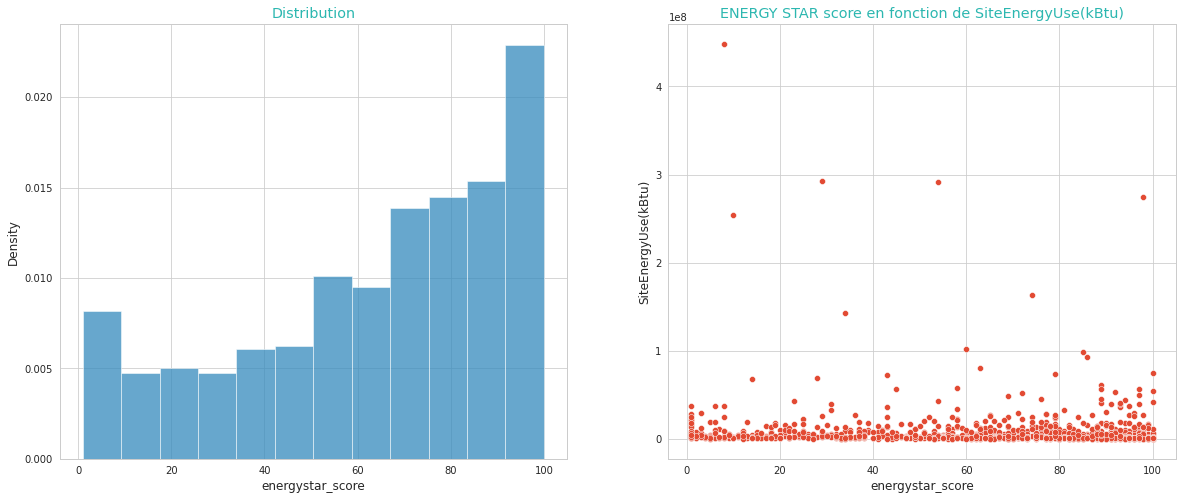

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=X, x='energystar_score', stat="density", ax=axes[0])
axes[0].set_title("Distribution", color='#2cb7b0')
sns.scatterplot(data=pd.concat([X,Y], axis=1), y='SiteEnergyUse(kBtu)', x='energystar_score', ax=axes[1])
axes[1].set_title("ENERGY STAR score en fonction de SiteEnergyUse(kBtu)", color='#2cb7b0')
#plt.suptitle("Analyse de la variable ENERGY STAR Score", fontdict=font_title, fontsize=22)
plt.show()

On remarque ici que le score ENERGY STAR ne semble pas avoir de corrélation importante avec les émissions de CO2. La distribution ne suit pas de loi normale et la majorité des batiments a un score supérieur à 50 (de bonne qualité voir de très bonne qualité).

In [ ]:
categorical_features_estar = ['NewBuildingType','NewPrimaryPropertyType','NewNeighborhood']
categorical_transformer_estar = OneHotEncoder()

numeric_features_estar = ['NumberofFloors','NumberofBuildings','haversine_distance',
                    'PropertyGFATotal','TotalUseTypeNumber','BuildingAge','energystar_score',
                    'GFABuildingRate','GFAParkingRate','GFAPerBuilding','GFAPerFloor']
numeric_transformer_estar = RobustScaler(unit_variance=True)

preprocessor_estar = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer_estar, categorical_features_estar),
    ('numeric', numeric_transformer_estar, numeric_features_estar)
])

In [ ]:
X_transf_estar = preprocessor_estar.fit_transform(X)

In [ ]:
X_train_transf_estar, X_test_transf_estar, Y_train_transf_estar, Y_test_transf_estar = train_test_split(X_transf_estar, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train_transf_estar.shape[0],
                                                            X_test_transf_estar.shape[0]))

Entrainement: 1235 lignes,
Test: 309 lignes.



On utilise ici le meilleur modèle calculé sur la variable SiteEnergyUse(kBtu) en incluant l'ENERGY STAR Score :

In [ ]:
xgb_grid_cv_log_tune_estar = Pipeline([
    ('grid_search_xgb_log_tune_estar', RandomizedSearchCV(
                            TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                            param_distributions=param_xgb,
                            n_iter=20,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])


SEU_xgb_model_log_tune_estar = xgb_grid_cv_log_tune_estar.fit(X_train_transf_estar, Y_train_transf_estar['SiteEnergyUse(kBtu)'])
SEU_xgb_results_log_tune_estar = model_scores(SEU_xgb_model_log_tune_estar, 'grid_search_xgb_log_tune_estar')

[15:08:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Meilleur score MAE : -3249727.731
Meilleur Score R2 : 0.632
Meilleurs paramètres : {'regressor__subsample': 0.7, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1.5, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.4, 'regressor__colsample_bytree': 0.9}
Temps moyen d'entrainement : 531.06s


In [ ]:
SEU_pred_estar = SEU_xgb_model_log_tune_estar.predict(X_test_transf_estar)
SEUmetrics_estar = metrics_model(Y_test_transf_estar['SiteEnergyUse(kBtu)'],SEU_pred_estar)
SEUmetrics_estar

,Métrique,Résultats
0,MAE,4.677295e+06
1,R²,4.176449e-01


In [ ]:
SEUmetrics = SEUmetrics.rename(columns={"Résultats" : "Sans ENERGY STAR"})
SEUmetrics['Avec ENERGY STAR'] = SEUmetrics_estar['Résultats']
SEUmetrics

,Métrique,Sans ENERGY STAR,Avec ENERGY STAR
0,MAE,4.915276e+06,4.677295e+06
1,R²,3.627769e-01,4.176449e-01


Les métriques se sont améliorées grâce à la prise en compte de l'ENERGY STAR Score. En revanche, cette variable est encore peu renseignée, il est donc difficile de savoir si cette amélioration est rééllement significative. Il faut également prendre en compte le bénéfice vis à vis du coût de cet ENERGY STAR Score.